# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try the TTM-1024-96 model.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1).

In [1]:
import math
import os
import tempfile

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import TinyTimeMixerForPrediction, TrackingCallback, count_parameters, load_dataset
from tsfm_public.toolkit.visualization import plot_predictions

2024-08-21 02:44:48.601192: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 02:44:48.643494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 02:44:49.383021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [3]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "ettm2"
DATA_ROOT_PATH = "/dccstor/tsfm23/datasets/"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

## Zero-shot evaluation method

In [4]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96, prediction_filter_length=None):
    # Get data
    _, _, dset_test = load_dataset(
        dataset_name=dataset_name,
        context_length=context_length,
        forecast_length=forecast_length,
        fewshot_fraction=1.0,
        dataset_root_path=DATA_ROOT_PATH,
    )

    # Load model
    if prediction_filter_length is None:
        zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION
        )
    else:
        if prediction_filter_length <= forecast_length:
            zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm-granite/granite-timeseries-ttm-v1",
                revision=TTM_MODEL_REVISION,
                prediction_filter_length=prediction_filter_length,
            )
        else:
            raise ValueError("`prediction_filter_length` should be <= `forecast_length")
    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        channel=0,
    )

 ## Few-shot finetune and evaluation method

In [5]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=0.001,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    prediction_filter_length=None,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset
    dset_train, dset_val, dset_test = load_dataset(
        dataset_name,
        context_length,
        forecast_length,
        fewshot_fraction=fewshot_percent / 100,
        dataset_root_path=DATA_ROOT_PATH,
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        if prediction_filter_length is None:
            finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION, head_dropout=0.7
            )
        elif prediction_filter_length <= forecast_length:
            finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm-granite/granite-timeseries-ttm-v1",
                revision=TTM_MODEL_REVISION,
                head_dropout=0.7,
                prediction_filter_length=prediction_filter_length,
            )
        else:
            raise ValueError("`prediction_filter_length` should be <= `forecast_length")
    else:
        if prediction_filter_length is None:
            finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm-granite/granite-timeseries-ttm-v1",
                revision=TTM_MODEL_REVISION,
            )
        elif prediction_filter_length <= forecast_length:
            finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm-granite/granite-timeseries-ttm-v1",
                revision=TTM_MODEL_REVISION,
                prediction_filter_length=prediction_filter_length,
            )
        else:
            raise ValueError("`prediction_filter_length` should be <= `forecast_length")
    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to=None,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)
    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        channel=0,
    )

## Example: downstream target dataset - ettm2

### Zero-shot

INFO:p-1156515:t-23103600448256:data_handling.py:load_dataset:Dataset name: ettm2, context length: 512, prediction length 96
INFO:p-1156515:t-23103600448256:data_handling.py:load_dataset:Data lengths: train = 33953, val = 11425, test = 11425
INFO:p-1156515:t-23103600448256:base.py:add_job:Adding job tentatively -- it will be properly scheduled when the scheduler starts


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.1860235333442688, 'eval_model_preparation_time': 0.0027, 'eval_runtime': 6.2043, 'eval_samples_per_second': 1841.456, 'eval_steps_per_second': 28.851}


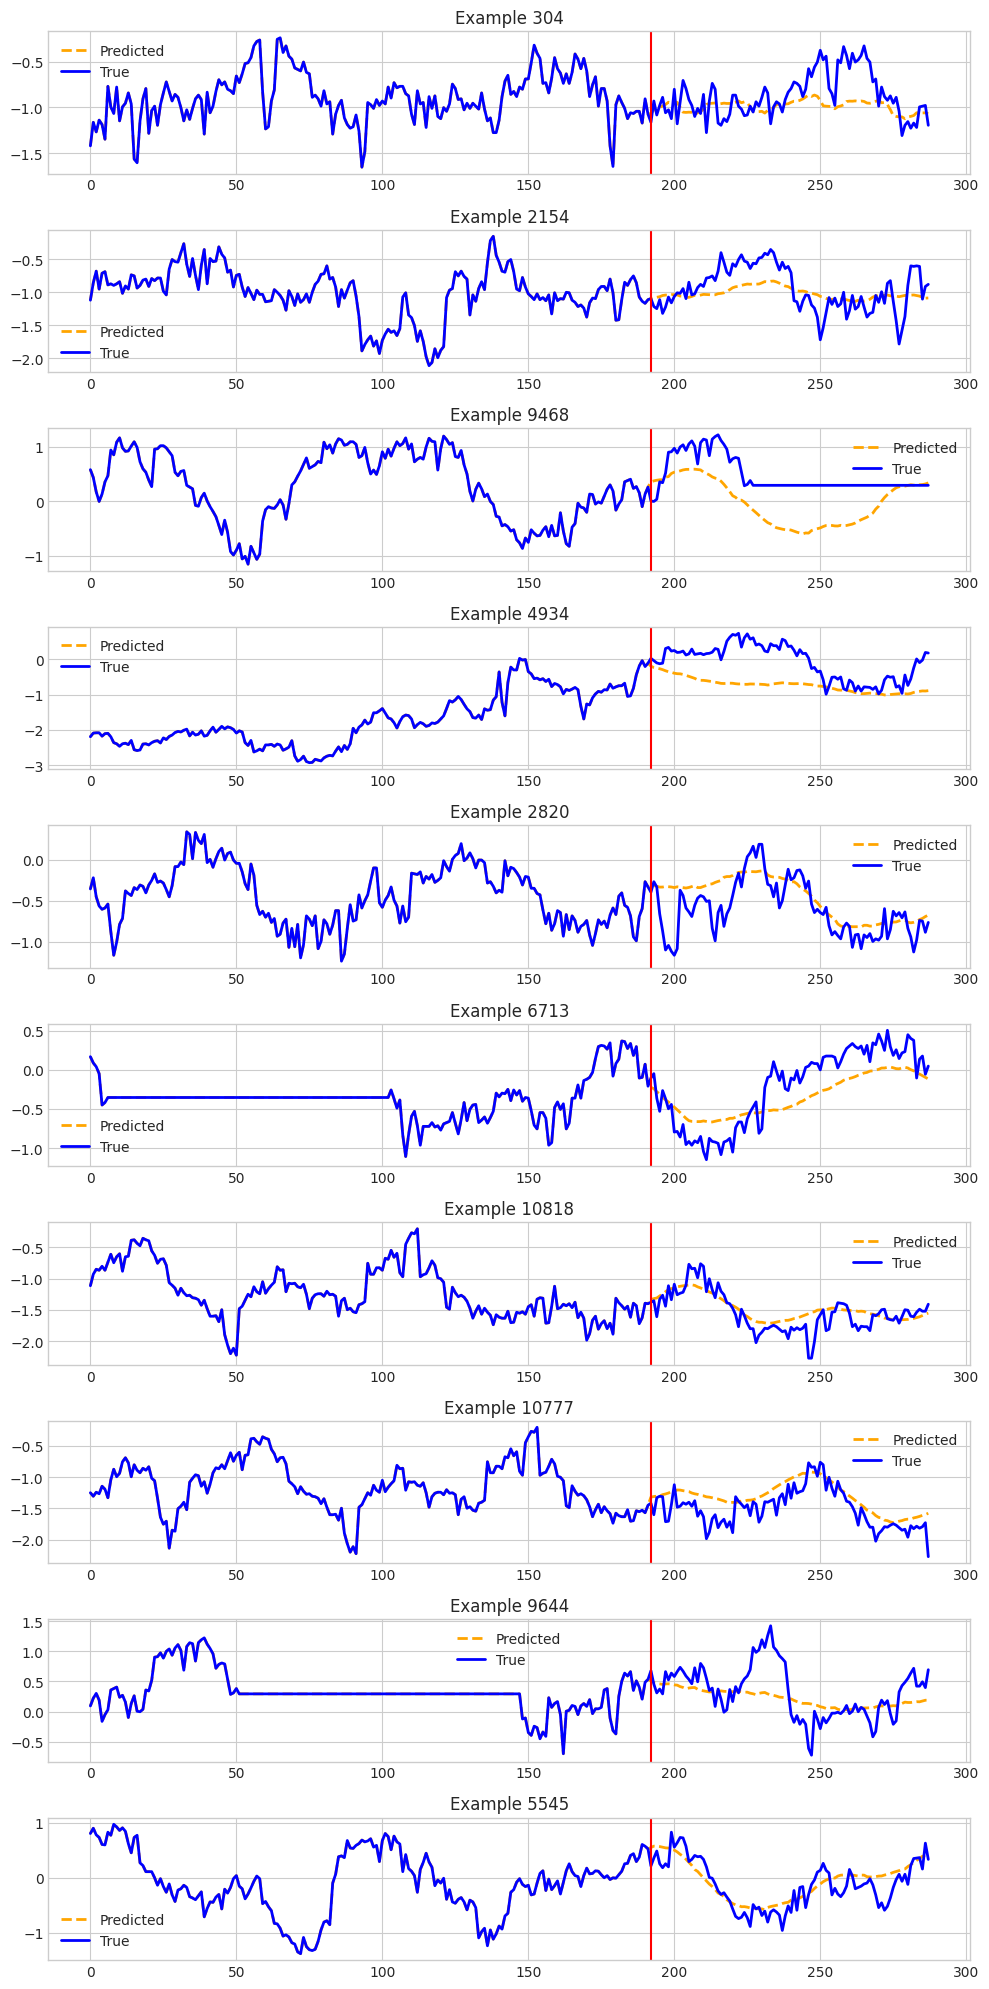

In [6]:
zeroshot_eval(dataset_name=target_dataset, batch_size=64)

### Few-shot 5%

INFO:p-1156515:t-23103600448256:data_handling.py:load_dataset:Dataset name: ettm2, context length: 512, prediction length 96


-------------------- Running few-shot 5% --------------------


INFO:p-1156515:t-23103600448256:data_handling.py:load_dataset:Data lengths: train = 1607, val = 11425, test = 11425
INFO:p-1156515:t-23103600448256:base.py:add_job:Adding job tentatively -- it will be properly scheduled when the scheduler starts


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


INFO:p-1156515:t-23103600448256:base.py:_real_add_job:Added job "EmissionsTracker._measure_power" to job store "default"
INFO:p-1156515:t-23103600448256:base.py:start:Scheduler started


Epoch,Training Loss,Validation Loss
1,0.403100,0.130643
2,0.340000,0.129244
3,0.283400,0.128597
4,0.238700,0.130647
5,0.197600,0.135873
6,0.178500,0.141251
7,0.160400,0.143489
8,0.151500,0.143133
9,0.144200,0.145625
10,0.141300,0.146513


INFO:p-1156515:t-23090098505472:base.py:run_job:Running job "EmissionsTracker._measure_power (trigger: interval[0:00:15], next run at: 2024-08-21 02:45:17 EDT)" (scheduled at 2024-08-21 02:45:17.565321-04:00)
INFO:p-1156515:t-23090098505472:base.py:run_job:Job "EmissionsTracker._measure_power (trigger: interval[0:00:15], next run at: 2024-08-21 02:45:32 EDT)" executed successfully
INFO:p-1156515:t-23103600448256:base.py:shutdown:Scheduler has been shut down


[TrackingCallback] Mean Epoch Time = 0.8486249446868896 seconds, Total Train Time = 32.356942892074585
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.17499123513698578, 'eval_runtime': 1.3448, 'eval_samples_per_second': 8495.681, 'eval_steps_per_second': 133.105, 'epoch': 13.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


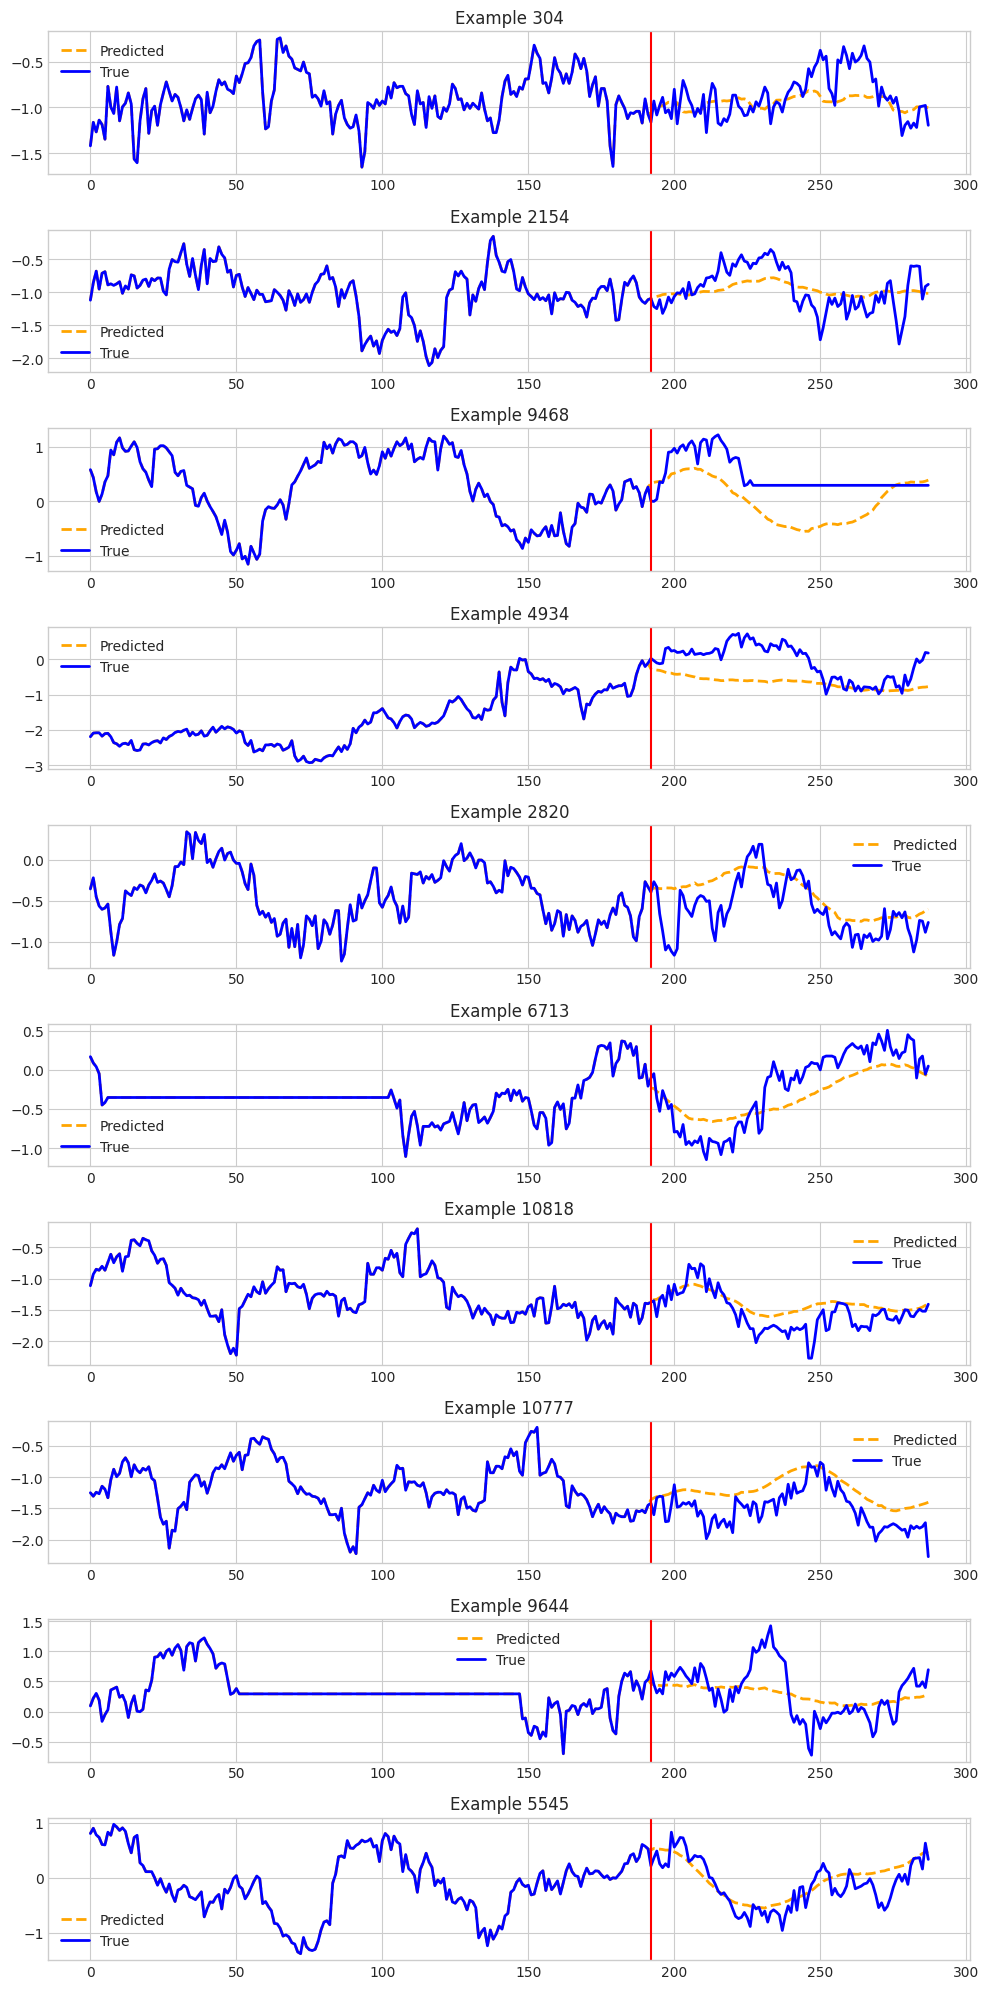

In [7]:
fewshot_finetune_eval(dataset_name=target_dataset, batch_size=64)

## Example: Automatically truncating the forecast horizon

Here, we demonstrate that a pre-trained 512-96 TTM model (i.e., context length = 512, forecast horizon = 96) 
can be used for a task having forecast horizon less than 96 time points.
We need to specify the argument `prediction_filter_length` while loading the model. That's it!

Note that the model performance might be sacrificed by some margin while truncating the model forecast. It is recommended to try 
this feature in your validation data for your experiment, to verify if the model performance is in the acceptable threshold. 
Otherwise, a new TTM model can be pre-trained with the required forecast horizon.

In this example, we will use a 512-96 TTM and use it on ettm2 data for forecasting 48 points in both zero-shot and 5% few-shot settings.

### Zero-shot

INFO:p-1156515:t-23103600448256:data_handling.py:load_dataset:Dataset name: ettm2, context length: 512, prediction length 96
INFO:p-1156515:t-23103600448256:data_handling.py:load_dataset:Data lengths: train = 33953, val = 11425, test = 11425
INFO:p-1156515:t-23103600448256:base.py:add_job:Adding job tentatively -- it will be properly scheduled when the scheduler starts


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.14195680618286133, 'eval_model_preparation_time': 0.0023, 'eval_runtime': 3.0003, 'eval_samples_per_second': 3807.98, 'eval_steps_per_second': 59.661}


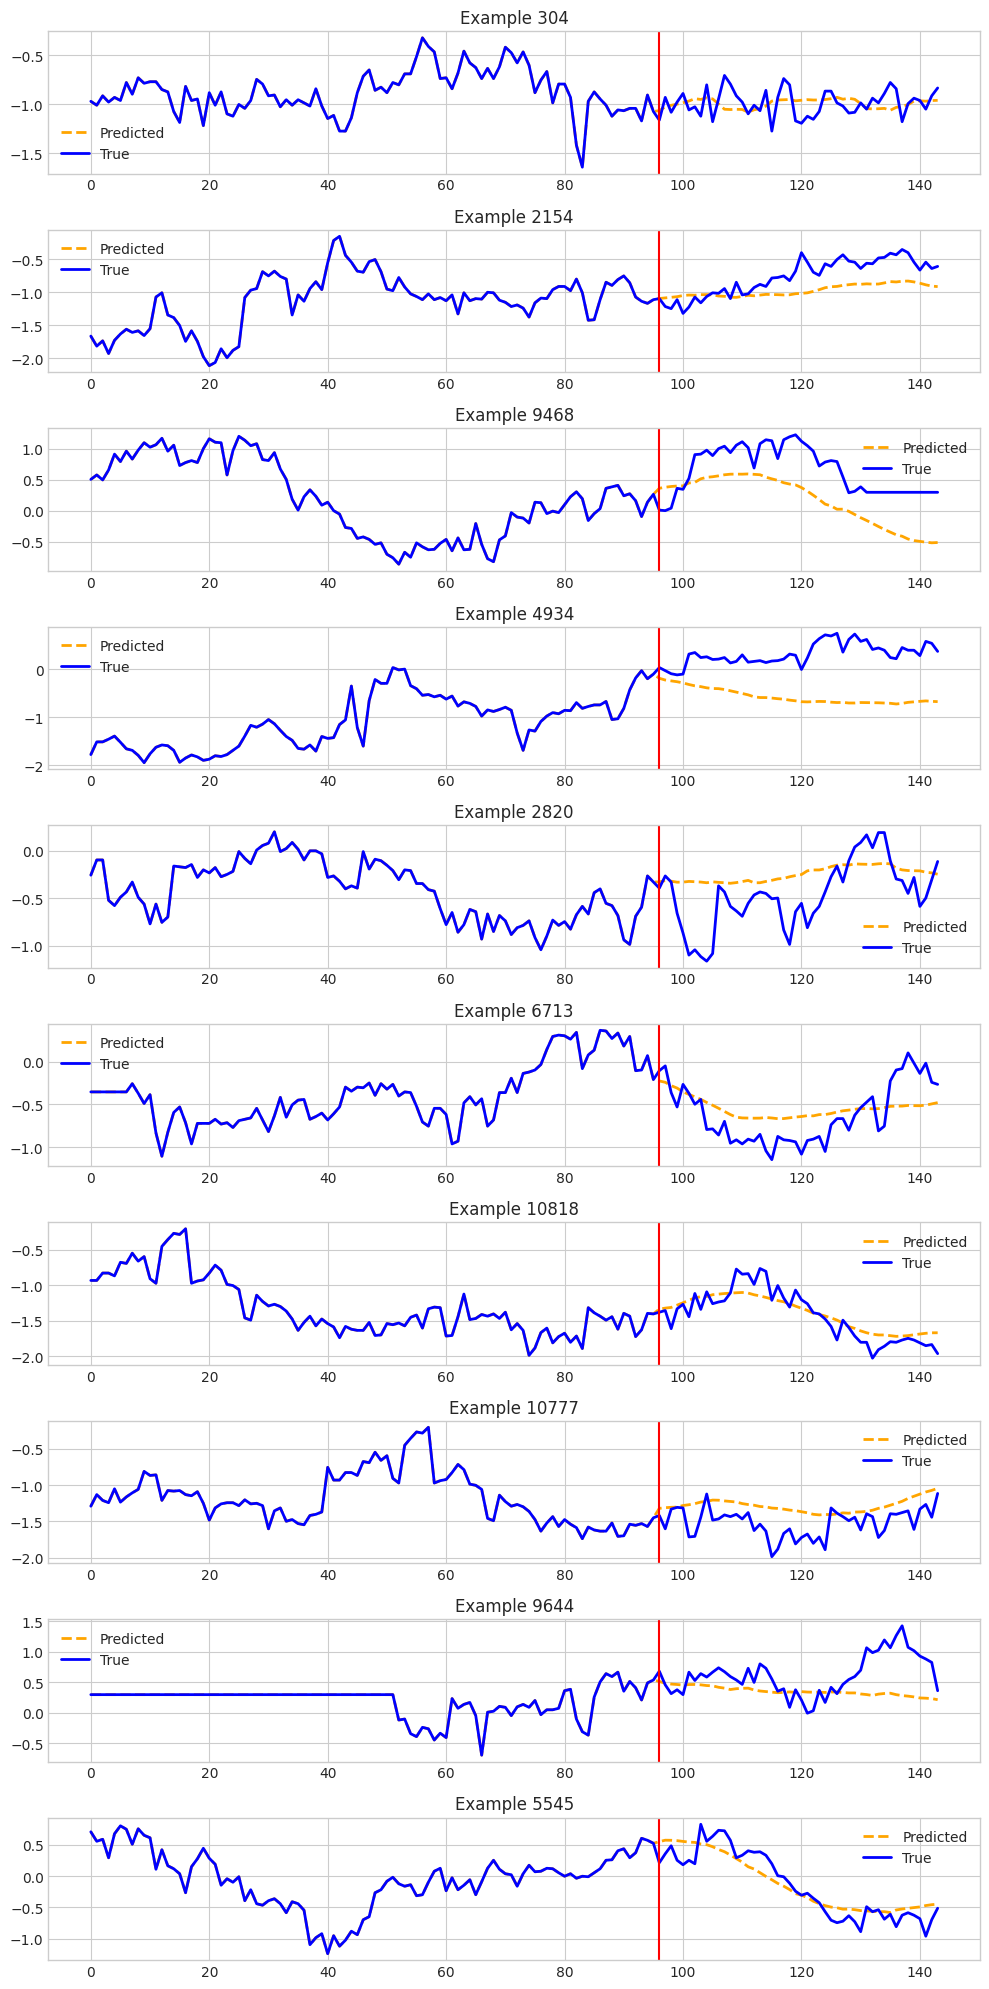

In [8]:
zeroshot_eval(dataset_name=target_dataset, batch_size=64, prediction_filter_length=48)

### Few-shot 5%

INFO:p-1156515:t-23103600448256:data_handling.py:load_dataset:Dataset name: ettm2, context length: 512, prediction length 96
INFO:p-1156515:t-23103600448256:data_handling.py:load_dataset:Data lengths: train = 1607, val = 11425, test = 11425


-------------------- Running few-shot 5% --------------------


INFO:p-1156515:t-23103600448256:base.py:add_job:Adding job tentatively -- it will be properly scheduled when the scheduler starts


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


INFO:p-1156515:t-23103600448256:base.py:_real_add_job:Added job "EmissionsTracker._measure_power" to job store "default"
INFO:p-1156515:t-23103600448256:base.py:start:Scheduler started


Epoch,Training Loss,Validation Loss
1,0.313100,0.108604
2,0.274600,0.107670
3,0.230800,0.107023
4,0.197900,0.107315
5,0.166000,0.109317
6,0.145000,0.112156
7,0.135400,0.112260
8,0.127300,0.111317
9,0.119700,0.112212
10,0.117000,0.112352


INFO:p-1156515:t-23090119517952:base.py:run_job:Running job "EmissionsTracker._measure_power (trigger: interval[0:00:15], next run at: 2024-08-21 02:45:59 EDT)" (scheduled at 2024-08-21 02:45:59.844523-04:00)
INFO:p-1156515:t-23090119517952:base.py:run_job:Job "EmissionsTracker._measure_power (trigger: interval[0:00:15], next run at: 2024-08-21 02:46:14 EDT)" executed successfully
INFO:p-1156515:t-23103600448256:base.py:shutdown:Scheduler has been shut down


[TrackingCallback] Mean Epoch Time = 0.7432115444770226 seconds, Total Train Time = 31.354000329971313
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.13661938905715942, 'eval_runtime': 1.353, 'eval_samples_per_second': 8443.896, 'eval_steps_per_second': 132.294, 'epoch': 13.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


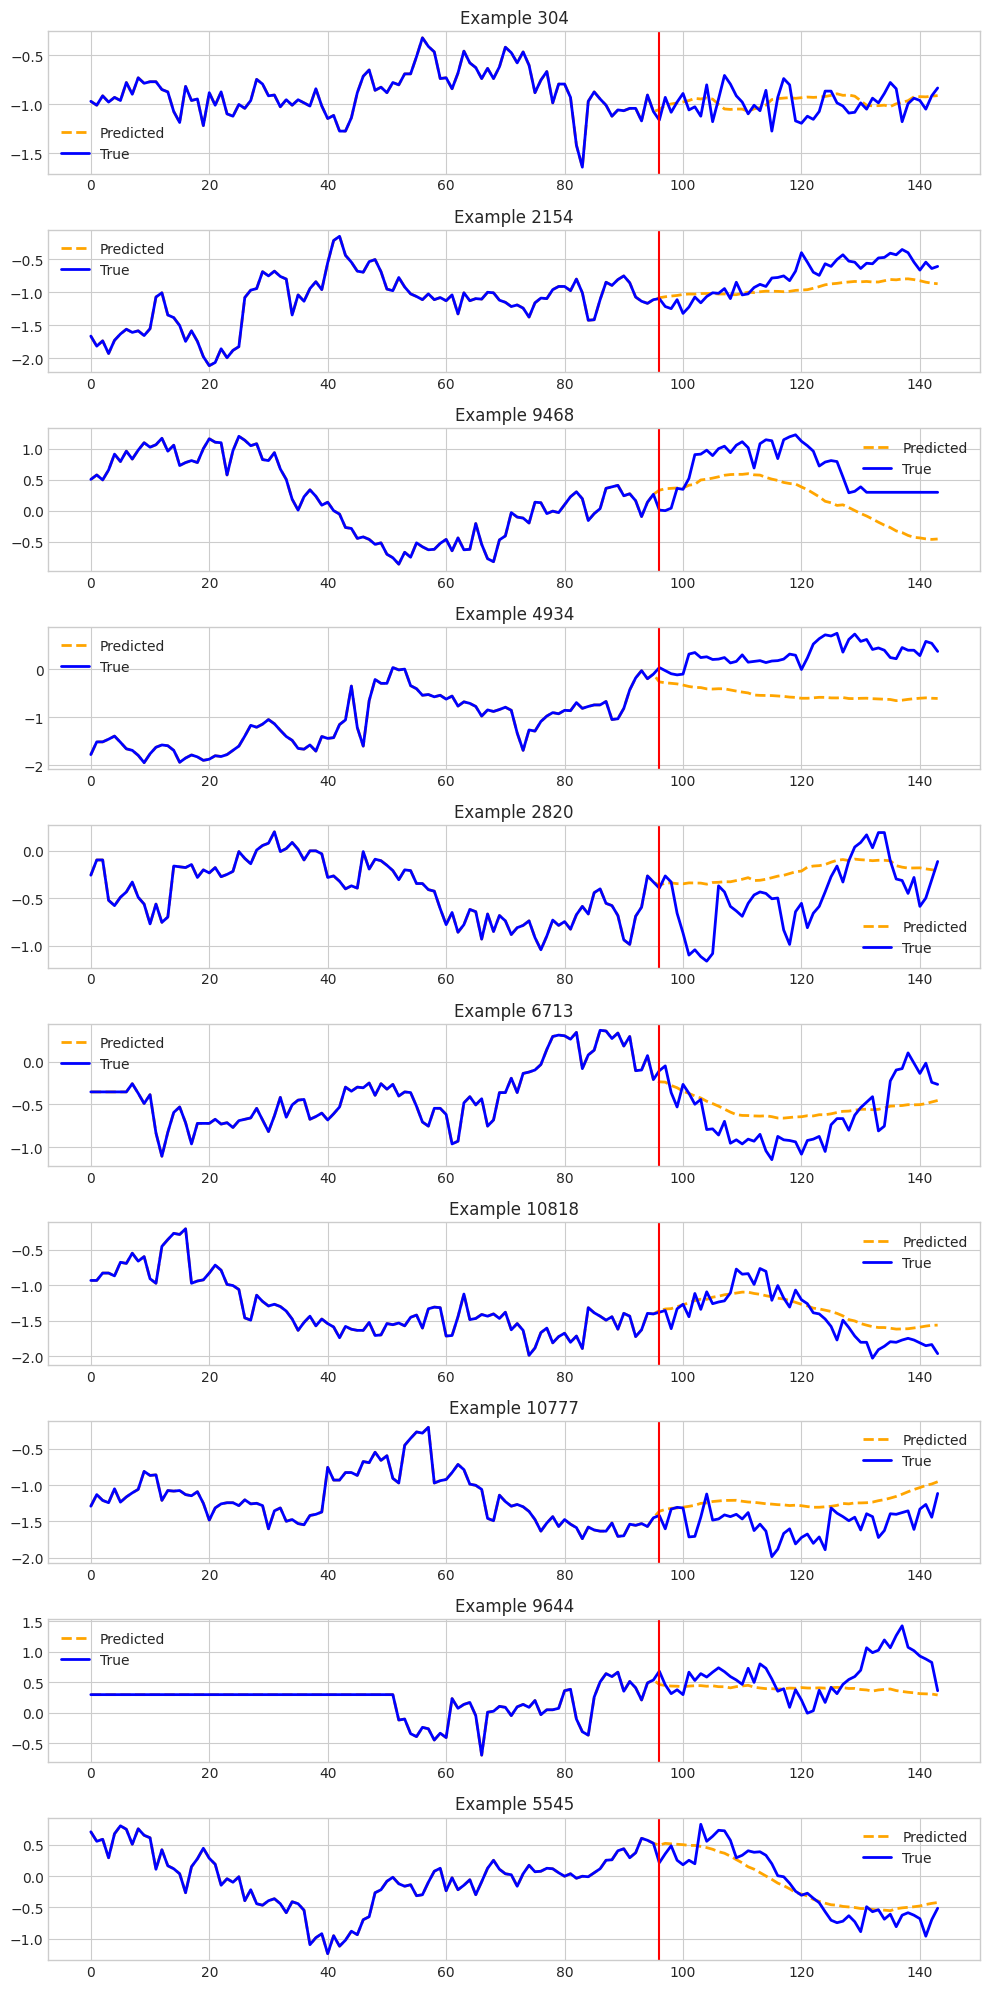

In [9]:
fewshot_finetune_eval(dataset_name=target_dataset, batch_size=64, prediction_filter_length=48)